# Demonstrate use of the [Intake](https://intake.readthedocs.io/en/latest/index.html) catalog prepared for the AODN

Not all the data available on the AODN S3 bucket has been indexed to allow 'cloud performant' access

## Step 0: Import the library of code

In [1]:
import sys
import os
sys.path.append(os.path.join(str(os.getcwd()),'../'))
import intake_aodn
import intake

## Step 1: Open and display the catalog

In [2]:
# Function to display the entries in an intake catalog
import pandas as pd #
def display_entry(entry):
    print(f'NAME: {entry.name}')
    print(f'DESCRIPTION: {entry.description}')
    print(f'TYPE: {entry.container}')
    print(f'METADATA: ')
    for k,v in entry.metadata.items():
       print(f'    {k} : {v}') 
    print('USER PARAMETERS:')
    user_params = pd.DataFrame(entry.describe()['user_parameters'])
    display(user_params)

The top level catalog just contains entries for other catalogs

In [3]:
cat = intake_aodn.cat

for entry in cat:
    display_entry(cat[entry])

NAME: aodn_s3
DESCRIPTION: AODN datasets indexed and available on AWS S3
TYPE: catalog
METADATA: 
    catalog_dir : /home/jovyan/intake-aodn/intake_aodn/catalogs/
USER PARAMETERS:


""


NAME: nci
DESCRIPTION: Datasets available on NCI Thredds Server
TYPE: catalog
METADATA: 
    catalog_dir : /home/jovyan/intake-aodn/intake_aodn/catalogs/
USER PARAMETERS:


""


We can access the entries of the catalog using '.' (dot) notation and loop through those. The 

In [4]:
for entry in cat.aodn_s3:
    display_entry(cat.aodn_s3[entry])

NAME: SST_L3S_1d_ngt
DESCRIPTION: IMOS - SRS - SST - L3S - Single Sensor - 1 day - night time - Australia
TYPE: xarray
METADATA: 
    permalink : https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/aaad092c-c3af-42e6-87e0-bdaef945f522
    catalog_dir : /home/jovyan/intake-aodn/intake_aodn/catalogs/
USER PARAMETERS:


,name,description,type,default,min,max
0,refs_bucket,The S3 bucket where the reference index is stored,str,imos-data-pixeldrill-refs,NaT,NaT
1,startdt,Start date of request,datetime,2021-06-01 00:00:00,1992-03-21,2021-06-30
2,enddt,End date of request,datetime,2021-06-30 00:00:00,1992-03-22,2021-06-30
3,geom,Geometry in Well Known Text format to subset q...,str,"POLYGON ((114. -34., 114. -31., 116. -31., 116...",NaT,NaT


In [5]:
for entry in cat.nci:
    display_entry(cat.nci[entry])

NAME: bran2020
DESCRIPTION: Bluelink Ocean Reanalysis - BRAN2020
TYPE: xarray
METADATA: 
    permalink : https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f9372_7752_2015_3718
    catalog_dir : /home/jovyan/intake-aodn/intake_aodn/catalogs/
USER PARAMETERS:


""


## Step 2: Open the SST catalog entry with some 'user supplied' parameters

In [6]:
import fiona # A library for lots of geospatial analysis
import geopandas as gpd # A library for opening shapefiles (and the like) and displaying their attribues and geometry
import matplotlib.pyplot as plt # A general purpose plotting library
import cartopy.crs as ccrs # Library for plotting maps in python
import cartopy.feature as cf # Library for plotting maps in python

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #adds support for reading KML to geopandas
gdf = gpd.read_file('SharkBay.kml', driver='KML')
gdf

,Name,Description,geometry
0,SharkBay,,"POLYGON Z ((113.61460 -24.56049 0.00000, 113.4..."


Make a quick plot of the polygon

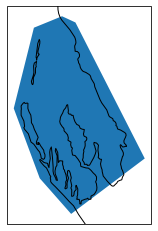

In [7]:
ax = plt.axes(projection = ccrs.PlateCarree())
gdf.plot(ax=ax)
ax.add_feature(cf.COASTLINE)

## Step 3: Read the data for the entry into memory for use

This subsets and composes the data across all the 365 files into a single dataset. The files are shown here: http://thredds.aodn.org.au/thredds/catalog/IMOS/SRS/SST/ghrsst/L3S-1d/ngt/2011/catalog.html. 

This takes a couple of minutes, but at the moment we are only using 1 cpu to loop through - later we will show how to speed it up by making use of more CPUs

Get an entry with our chosen input user parameters, in this instance 2011

In [8]:
%%time
entry=intake_aodn.cat.aodn_s3.SST_L3S_1d_ngt(startdt='2011-01-01',
                                             enddt='2012-01-01',
                                             geom=str(gdf.geometry[0])) # Geometry string in WKT

ds = entry.read()
ds

CPU times: user 2min 9s, sys: 11.2 s, total: 2min 20s
Wall time: 50.2 s


<xarray.Dataset>
Dimensions:                  (time: 365, latitude: 114, longitude: 84)
Coordinates:
  * latitude                 (latitude) float32 -24.49 -24.51 ... -26.73 -26.75
  * longitude                (longitude) float32 112.8 112.8 ... 114.5 114.5
  * time                     (time) datetime64[ns] 2011-01-01T15:20:00 ... 20...
Data variables:
    dt_analysis              (time, latitude, longitude) float32 nan nan ... nan
    l2p_flags                (time, latitude, longitude) float32 nan nan ... 2.0
    quality_level            (time, latitude, longitude) float32 nan nan ... nan
    satellite_zenith_angle   (time, latitude, longitude) float32 nan nan ... nan
    sea_surface_temperature  (time, latitude, longitude) float32 nan nan ... nan
    sses_bias                (time, latitude, longitude) float32 nan nan ... nan
    sses_count               (time, latitude, longitude) float32 nan nan ... nan
    sses_standard_deviation  (time, latitude, longitude) float32 nan nan ... nan
    sst_dtime                (time, latitude, longitude) float64 nan nan ... nan
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          Skin SST retrievals produced from stitc...
    time_coverage_end:                20110101T205806Z
    time_coverage_start:              20110101T132645Z
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    uuid:                             5bc0e9b4-a261-42d2-bd31-0cccd1878500
    westernmost_longitude:            70.01000213623047

## Step 4: Save the data to netcdf

In [9]:
# Need to drop the "NAME" and "_Netcdf4Dimid" which are reserved when writing back out to netCDF
# Unclear why they are in there dataset
for v in ds.variables:
    for bad_attr in ['_Netcdf4Dimid','NAME']:
        if bad_attr in ds[v].attrs.keys():
            del ds[v].attrs[bad_attr]
            
ds.to_netcdf('SharkBay_SST_2011.nc')

Open the saved data to convince ourselves it has saved correctly

In [10]:
import xarray as xr
ds = xr.open_dataset('SharkBay_SST_2011.nc')
ds

<xarray.Dataset>
Dimensions:                  (time: 365, latitude: 114, longitude: 84)
Coordinates:
  * latitude                 (latitude) float32 -24.49 -24.51 ... -26.73 -26.75
  * longitude                (longitude) float32 112.8 112.8 ... 114.5 114.5
  * time                     (time) datetime64[ns] 2011-01-01T15:20:00 ... 20...
Data variables:
    dt_analysis              (time, latitude, longitude) float32 ...
    l2p_flags                (time, latitude, longitude) float32 ...
    quality_level            (time, latitude, longitude) float32 ...
    satellite_zenith_angle   (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    sses_bias                (time, latitude, longitude) float32 ...
    sses_count               (time, latitude, longitude) float32 ...
    sses_standard_deviation  (time, latitude, longitude) float32 ...
    sst_dtime                (time, latitude, longitude) float64 ...
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          Skin SST retrievals produced from stitc...
    time_coverage_end:                20110101T205806Z
    time_coverage_start:              20110101T132645Z
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    uuid:                             5bc0e9b4-a261-42d2-bd31-0cccd1878500
    westernmost_longitude:            70.01000213623047

## Step 4: Open the datafiles in S3 and but dont read any data, just the 'metadata' 

This is useful if the data is large and wont fit into memory - note the arrays no longer have values in them, but rather are [DASK](https://docs.dask.org/en/stable/index.html) arrays to allow for parallel computing.

This returns quicker, but the data has to be loaded later during the calculation.


In [11]:
%%time
entry=intake_aodn.cat.aodn_s3.SST_L3S_1d_ngt(startdt='2011-01-01',
                                             enddt='2012-01-01',
                                             geom=str(gdf.geometry[0])) 
ds = entry.to_dask()
ds

CPU times: user 789 ms, sys: 37.4 ms, total: 826 ms
Wall time: 806 ms


<xarray.Dataset>
Dimensions:                  (time: 365, latitude: 114, longitude: 84)
Coordinates:
  * latitude                 (latitude) float32 -24.49 -24.51 ... -26.73 -26.75
  * longitude                (longitude) float32 112.8 112.8 ... 114.5 114.5
  * time                     (time) datetime64[ns] 2011-01-01T15:20:00 ... 20...
Data variables:
    dt_analysis              (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    l2p_flags                (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    quality_level            (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    satellite_zenith_angle   (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    sea_surface_temperature  (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    sses_bias                (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    sses_count               (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    sses_standard_deviation  (time, latitude, longitude) float32 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
    sst_dtime                (time, latitude, longitude) float64 dask.array<chunksize=(365, 114, 84), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          Skin SST retrievals produced from stitc...
    time_coverage_end:                20110101T205806Z
    time_coverage_start:              20110101T132645Z
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    uuid:                             5bc0e9b4-a261-42d2-bd31-0cccd1878500
    westernmost_longitude:            70.01000213623047

## Step 5: Create a small cluster within the machine that our notebook is running on 

The machine has 8 cores and 32GB of memory as you can see from expanding the "Cluster Info" below

In [12]:
from intake_aodn.utils import get_local_cluster
client = get_local_cluster()
client

/env/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39639 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/bra467/proxy/39639/status,
Dashboard: /user/bra467/proxy/39639/status,Workers: 4
Total threads: 8,Total memory: 28.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40285,Workers: 4
Dashboard: /user/bra467/proxy/39639/status,Total threads: 8
Started: Just now,Total memory: 28.00 GiB
Comm: tcp://10.0.116.174:35759,Total threads: 2
Dashboard: /user/bra467/proxy/44197/status,Memory: 7.00 GiB
Nanny: tcp://127.0.0.1:44693,


In [13]:
%%time
entry=intake_aodn.cat.aodn_s3.SST_L3S_1d_ngt(startdt='2011-01-01',
                                             enddt='2012-01-01',
                                             geom=str(gdf.geometry[0])) 
ds = entry.to_dask()

ds = ds.load()
ds

CPU times: user 5.19 s, sys: 869 ms, total: 6.06 s
Wall time: 36.6 s


<xarray.Dataset>
Dimensions:                  (time: 365, latitude: 114, longitude: 84)
Coordinates:
  * latitude                 (latitude) float32 -24.49 -24.51 ... -26.73 -26.75
  * longitude                (longitude) float32 112.8 112.8 ... 114.5 114.5
  * time                     (time) datetime64[ns] 2011-01-01T15:20:00 ... 20...
Data variables:
    dt_analysis              (time, latitude, longitude) float32 nan nan ... nan
    l2p_flags                (time, latitude, longitude) float32 nan nan ... 2.0
    quality_level            (time, latitude, longitude) float32 nan nan ... nan
    satellite_zenith_angle   (time, latitude, longitude) float32 nan nan ... nan
    sea_surface_temperature  (time, latitude, longitude) float32 nan nan ... nan
    sses_bias                (time, latitude, longitude) float32 nan nan ... nan
    sses_count               (time, latitude, longitude) float32 nan nan ... nan
    sses_standard_deviation  (time, latitude, longitude) float32 nan nan ... nan
    sst_dtime                (time, latitude, longitude) float64 nan nan ... nan
Attributes: (12/50)
    Conventions:                      CF-1.6
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    Metadata_Link:                    TBA
    acknowledgment:                   Any use of these data requires the foll...
    cdm_data_type:                    grid
    comment:                          HRPT AVHRR experimental L3 retrieval pr...
    ...                               ...
    summary:                          Skin SST retrievals produced from stitc...
    time_coverage_end:                20110101T205806Z
    time_coverage_start:              20110101T132645Z
    title:                            IMOS L3S Nighttime gridded multiple-sen...
    uuid:                             5bc0e9b4-a261-42d2-bd31-0cccd1878500
    westernmost_longitude:            70.01000213623047

## Step 6: Calculate the monthly mean and plot the data


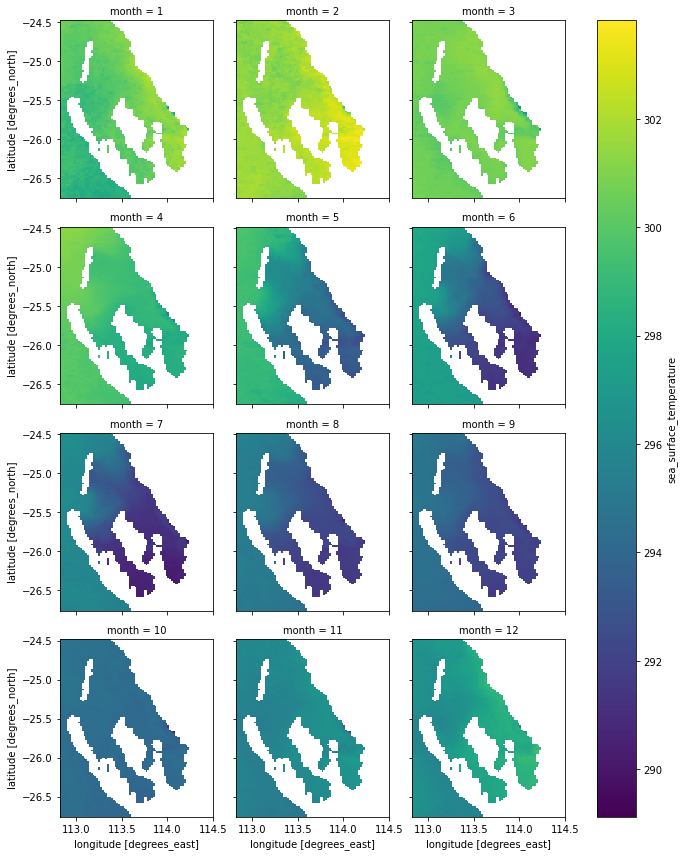

In [16]:
monthly_mean=ds.sea_surface_temperature.groupby('time.month').mean()
monthly_mean.plot(x='longitude',y='latitude',col='month',col_wrap=3)